# Warsztaty Python w Data Science

---

## Machine Learning - część 5 z 5. Nauczanie przez wzmocnienie
- ### Kółko i krzyżyk
- ### Q-Learning i Wzór Bellmana
- ### Q-Player z wyżarzaniem
- ### Testy A/B - problem eksploracji i eksploatacji
- ### Problem wielorękiego bandyty i __*bandit algorithms*__
  - #### ε-greedy (ε-zachłanny)
  - #### ε-first
  - #### SoftMax
  - #### SoftMax z wyżarzaniem
  
  

---

## Nauczanie Maszynowe to:

- ### Uczenie z nadzorem (ang. *Supervised Learning*)
- ### Uczenie bez nadzoru (ang. *Unsupervised Learning*)
- ### __Uczenie ze wzmocnieniem (ang. *Reinforcement Learning*)__

---

## Kółko i krzyżyk

In [1]:
def cell(x):
    try:
        if x.lower()=="x":
            return " X "
        if x.lower()=="o":
            return " O "
    except:
        pass
    return "   "

In [2]:
def print_state(state):
    sep = "_"*11+"\n"
    ret = []
    n=0
    for row in state:
        ret.append("|".join(map(cell,row)))
        n+=1
        if n<3:
                ret.append(sep)
    for line in ret:
        print(line)

In [3]:
state = (('x','o',0.0),
         ('o','x',0.0),
         (0.0,'o','x'))
print_state(state)

 X | O |   
___________

 O | X |   
___________

   | O | X 


In [4]:
def has_won(state):
    players = ['x', 'o']
    for i in [0,1]:
        for row in state:
            if row==tuple(players[i]*3): # _
                return i, True
        for cols in [0, 1, 2]:
            if state[0][cols]==state[1][cols] and state[2][cols]==state[0][cols] and state[0][cols]==players[i]: # |
                return i, True
        if state[0][0]==state[1][1] and state[0][0]==state[2][2] and state[0][0]==players[i]:   # \
                return i, True
        if state[2][0]==state[1][1] and state[2][0]==state[0][2] and state[0][2]==players[i]:   # /
                return i, True
            
    return -1, False

In [5]:
def is_full(state):
    for row in state:
        for v in row:
            if v!="x" and v!="o":
                return False
    return True

def is_valid_move(state, x, y):
    row = state[x]
    if row[y]!="x" and row[y]!="o":
        return True
    return False

def new_state(state, x, y, character):
    l = []
    for row in state:
        l.append(list(row))
    l[x][y] = character
    return (tuple(l[0]), tuple(l[1]), tuple(l[2]))

In [6]:
import random

class Player:
    def move(state):
        return state
    def learn(self, won):
        pass

    
class HumanPlayer(Player):
    def __init__(self, character):
        self.character=character
        
    def move(self, state):
        print_state(state)
        flag = False
        while not flag:
            print()
            x = int(input(f"({self.character}) row: "))
            y = int(input(f"({self.character}) col: "))
            flag=is_valid_move(state, x, y)
        print()
        
        return new_state(state, x, y, self.character)

    
class RandomPlayer(Player):
    def __init__(self, character):
        self.character=character
        
    def move(self, state):
        flag = False
        while not flag:
            x = random.randrange(3)
            y = random.randrange(3)
            flag=is_valid_move(state, x, y)
       
        return new_state(state, x, y, self.character)

In [7]:
def do_game(player0, player1, stats, verbose=False):
    state = ((0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0))
    ended = False
    full = False
    won_won = -1
    
    while not ended and not full:
        state = player0.move(state)
        who_won, ended = has_won(state)
        full = is_full(state)        
        if not ended and not full:
            state = player1.move(state)
            who_won, ended = has_won(state)
            full = is_full(state)
    if ended:
        stats.append("WIN 0" if who_won==0 else "WIN 1")
        player0.learn(1.0 if who_won==0 else 0.0)
        player1.learn(1.0 if who_won==1 else 0.0)
    if full and not ended:
        stats.append("DRAW")    
        player0.learn(0.5)
        player1.learn(0.5)
    if verbose:
        print("DRAW" if full and not ended else f"{who_won} has WON!")
        print()
        print_state(state)

In [8]:
do_game(HumanPlayer('x'), RandomPlayer('o'), [], True)

   |   |   
___________

   |   |   
___________

   |   |   



(x) row:  1
(x) col:  1



   |   |   
___________

   | X |   
___________

 O |   |   



(x) row:  2
(x) col:  2



 O |   |   
___________

   | X |   
___________

 O |   | X 



(x) row:  1
(x) col:  0



 O |   | O 
___________

 X | X |   
___________

 O |   | X 



(x) row:  1
(x) col:  2



0 has WON!

 O |   | O 
___________

 X | X | X 
___________

 O |   | X 


Counter({'WIN 0': 596, 'WIN 1': 277, 'DRAW': 127})


<Figure size 432x288 with 0 Axes>

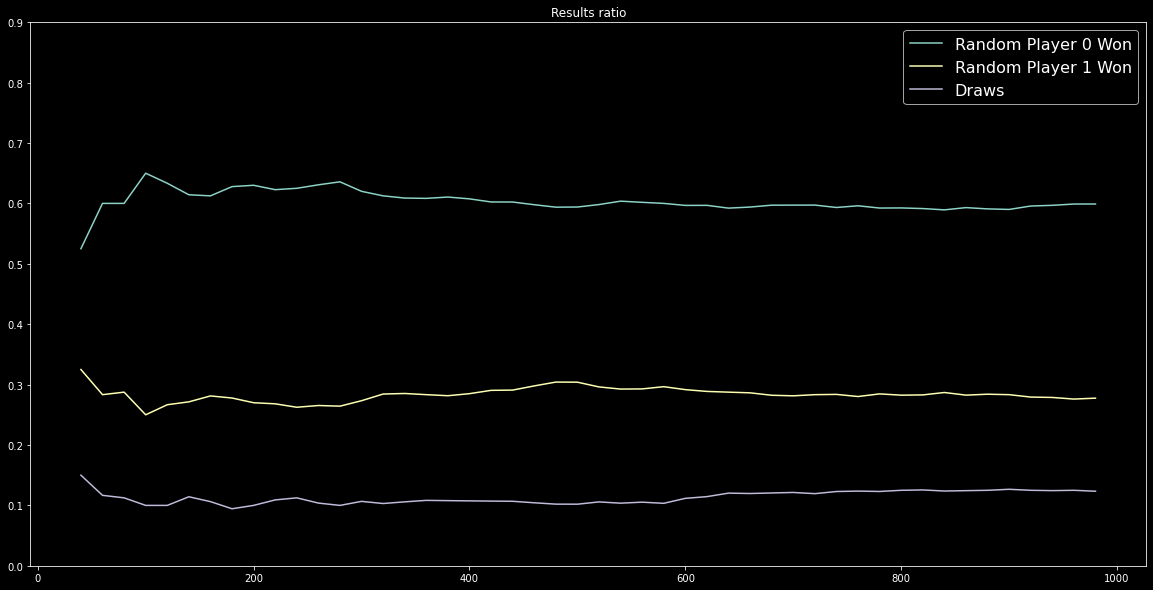

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

plt.style.use("dark_background")

stats = []
for i in range(1_000):
    do_game(RandomPlayer('x'), RandomPlayer('o'), stats, False)
    
print(Counter(stats))


def plot_games(qstats, label0, label1):
    games = range(40, len(qstats), 20)
    won0 = [ Counter(qstats[:x])['WIN 0']/x for x in games]
    won1 = [ Counter(qstats[:x])['WIN 1']/x for x in games]
    draw = [ Counter(qstats[:x])['DRAW']/x for x in games]


    fig = plt.figure();
    plt.figure(figsize=(20,10));
    plt.ylim([0.0, 0.9])
    plt.title('Results ratio');
    player0, = plt.plot(games, won0, label=label0);
    player1, = plt.plot(games, won1, label=label1);
    draws, = plt.plot(games, draw, label="Draws");
    plt.legend(handles=[player0, player1,  draws], frameon=True, loc="best",  fontsize=16);
    plt.show();

plot_games(stats, "Random Player 0 Won", "Random Player 1 Won");



---
# _*Q-Learning*_

https://en.wikipedia.org/wiki/Markov_chain

https://en.wikipedia.org/wiki/Q-learning

$
Q: S \times A \rightarrow I\!R
$
---

## W danym kroku $s$ podejmujemy akcję $a$ która maksymalizuje $Q$

---


## $Q$ Może zostać stabularyzowana (tzn. wsadzona do słownika)
## Kluczami są pary `(stan, akcja)` a wartością wynik $Q$


---
# Uczymy się $Q$ korzytając ze __*Wzoru Bellmana*__


$
Q^{new}(s_t, a_t) = Q(s_t, a_t) + \alpha \cdot ( r_t +  \gamma \cdot   \max_{a}Q(s_{t+1}, a) - Q(s_t, a_t) )
$
---
#### Upraszczając:

$
Q^{new}(s_t, a_t) = (1- \alpha) \cdot Q(s_t, a_t) + \alpha \cdot  \gamma \cdot   \max_{a}Q(s_{t+1}, a)
$
---



### $\alpha$ - Tempo uczenia się

### $\gamma$ - Degradacja wagi z odległością od bodźca

### $r_t$ - nagroda w danym stanie

---

In [10]:
α = 0.15 # Tempo uczenia się
β = 0.60 # Wartość początkowa `Q` - 'agresja'
γ = 0.99 # Degradacja wagi z odległością od bodźca 

---

In [11]:
from random import sample


class QPlayer(Player):
    def __init__(self, character):
        self.character=character
        #################################################                     
        ## stabularyzowane Q  postaci:                 ##
        ## { stan1:                                    ##   
        ##     { nowy_stan1: q1, nowy_stan2: q2, ...}, ##
        ##   stan2:                                    ##
        ##     { nowy_stan3: q3, nowy_stan4: q4, ...}, ##
        ##  ... }                                      ##
        #################################################                     
        self.q_table={}
        
        self.previous_state=None
        self.current_state=((0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0))
        
    def initialize_q_table(self, state):    
        actions = {}   
        for x in range(3):
            for y in range(3):
                if is_valid_move(state, x, y):
                    ##################################
                    ## Inicjalizacja przez β (beta) ##
                    ##################################
                    actions[
                        new_state(state, x, y, self.character)
                    ] = β
        self.q_table[state] = actions
        
        return actions
        
    def move(self, state):
        
        ##############################################################
        ## Tworzę powiązanie z ruchem drugiego gracza,              ##
        ## Aby w Q-table był ciągły łańcuch od poprzedniego ruchu   ##
        ##############################################################
        
        if self.previous_state:
            actions = self.q_table.get(self.current_state, {})
            if state not in actions.keys():
                actions[state] = β
                self.q_table[self.current_state] = actions
            
        ##############################################################
        ## Jeśli w Q-table nie ma akcji powiązanych z obecnym       ##
        ## stanem, dopisuje wszystkie możliwe akcje z wagą β (beta) ##
        ##############################################################
        actions = self.q_table.get(state)
        if not actions:
            actions = self.initialize_q_table(state)

        ##############################################################
        ## Biorę najlepsze Q dla akcji w tym stanie                 ##
        ##############################################################
        best_q = max(actions.values())
        
        ##############################################################
        ## Losuję akcję pośród tych co mają najlepsze Q             ##
        ##############################################################
        best_actions = [ action for action, q in actions.items() if q==best_q ]
 
        self.previous_state = state
        self.current_state = sample(best_actions, 1)[0]

        return self.current_state
    
    def learn(self, learned_weight):
        
        self.q_table[self.previous_state][self.current_state] = learned_weight
        self.previous_state=None
        
        for state, actions in self.q_table.items():
            for next_move, q in actions.items():
                next_move_actions = self.q_table.get(next_move)
                if next_move_actions:
                    best_next_q = max(next_move_actions.values())
                   
                    #########################
                    ##    Wzór Bellmana    ##
                    #########################
                    actions[next_move] = (1-α)*q + γ*α*best_next_q 
                    
                    self.q_table[state] = actions

In [12]:
qstats = []
qplayer = QPlayer('o')

In [13]:
from collections import Counter

for i in range(1):
    do_game(RandomPlayer('x'), qplayer, qstats, False)
    
print(Counter(qstats))


Counter({'WIN 0': 1})


In [14]:
from pprint import pprint 
pprint(qplayer.q_table)

{((0.0, 0.0, 0.0), (0.0, 'x', 0.0), (0.0, 0.0, 'o')): {((0.0, 'x', 0.0), (0.0, 'x', 0.0), (0.0, 0.0, 'o')): 0.5991},
 ((0.0, 'x', 'x'), (0.0, 'x', 0.0), ('o', 0.0, 'o')): {(('o', 'x', 'x'), (0.0, 'x', 0.0), ('o', 0.0, 'o')): 0.0,
                                                       ((0.0, 'x', 'x'), (0.0, 'x', 0.0), ('o', 'o', 'o')): 0.6,
                                                       ((0.0, 'x', 'x'), (0.0, 'x', 'o'), ('o', 0.0, 'o')): 0.6,
                                                       ((0.0, 'x', 'x'), ('o', 'x', 0.0), ('o', 0.0, 'o')): 0.6},
 ((0.0, 'x', 0.0), (0.0, 'x', 0.0), ('o', 0.0, 'o')): {((0.0, 'x', 'x'), (0.0, 'x', 0.0), ('o', 0.0, 'o')): 0.5991},
 ((0.0, 'x', 0.0), (0.0, 'x', 0.0), (0.0, 0.0, 'o')): {((0.0, 'x', 0.0), ('o', 'x', 0.0), (0.0, 0.0, 'o')): 0.6,
                                                       ((0.0, 'x', 0.0), (0.0, 'x', 'o'), (0.0, 0.0, 'o')): 0.6,
                                                       ((0.0, 'x', 0.0), (0.0, 'x', 0.0

Counter({'WIN 1': 1122, 'WIN 0': 756, 'DRAW': 123})


<Figure size 432x288 with 0 Axes>

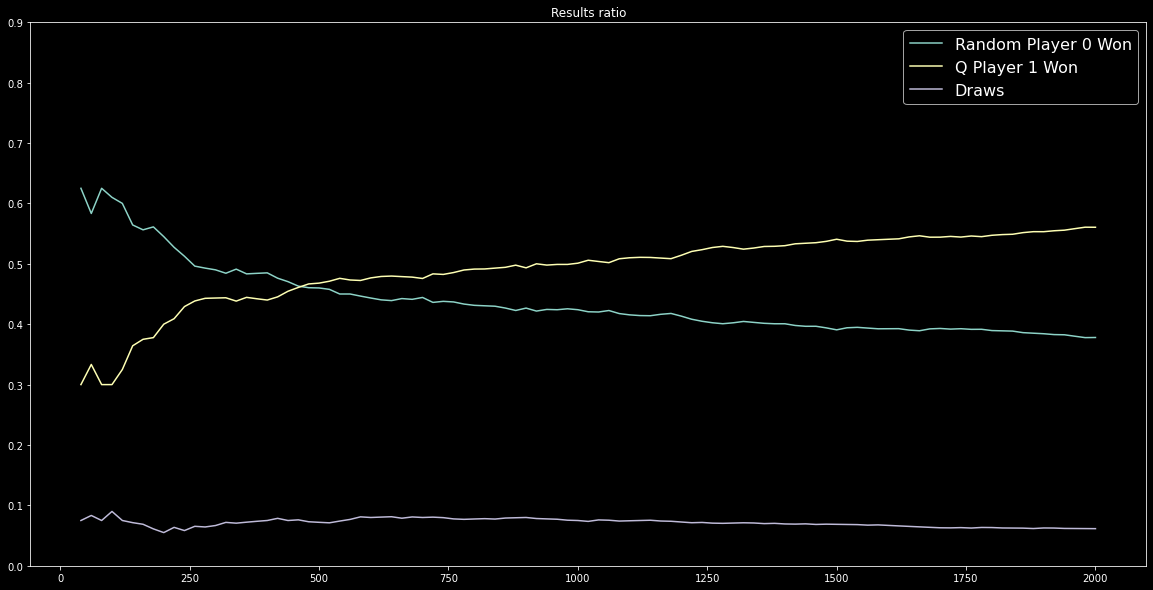

In [15]:
for i in range(2_000):
    do_game(RandomPlayer('x'), qplayer,  qstats, False)
    
print(Counter(qstats))
plot_games(qstats, "Random Player 0 Won", "Q Player 1 Won")

Counter({'WIN 1': 2448, 'WIN 0': 1340, 'DRAW': 213})


<Figure size 432x288 with 0 Axes>

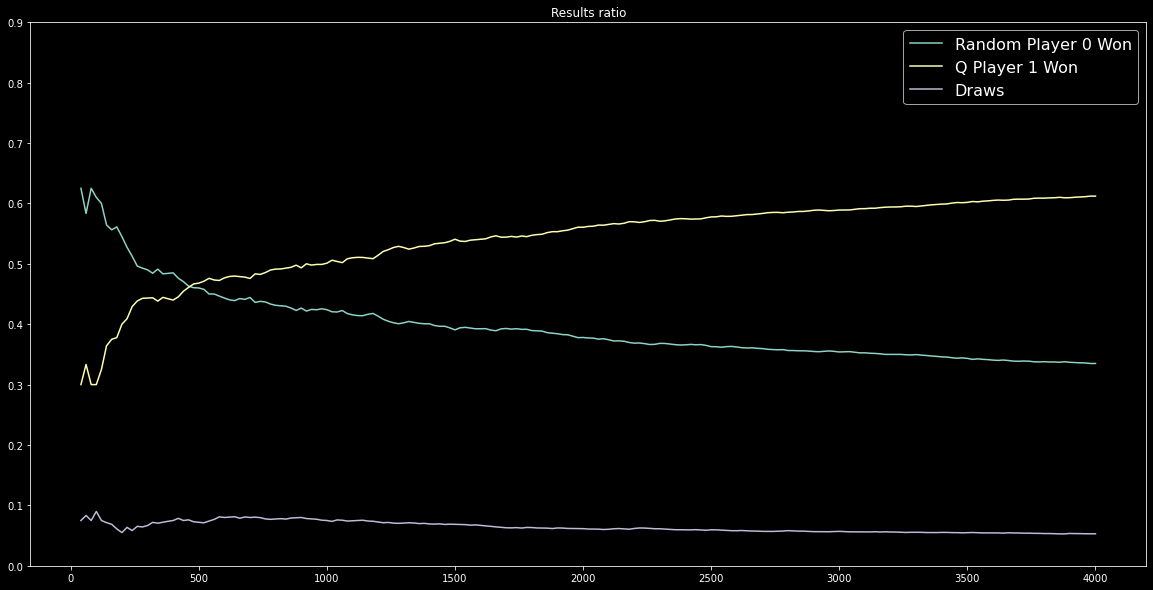

In [16]:
for i in range(2_000):
    do_game(RandomPlayer('x'), qplayer,  qstats, False)
    
print(Counter(qstats))
plot_games(qstats, "Random Player 0 Won", "Q Player 1 Won")

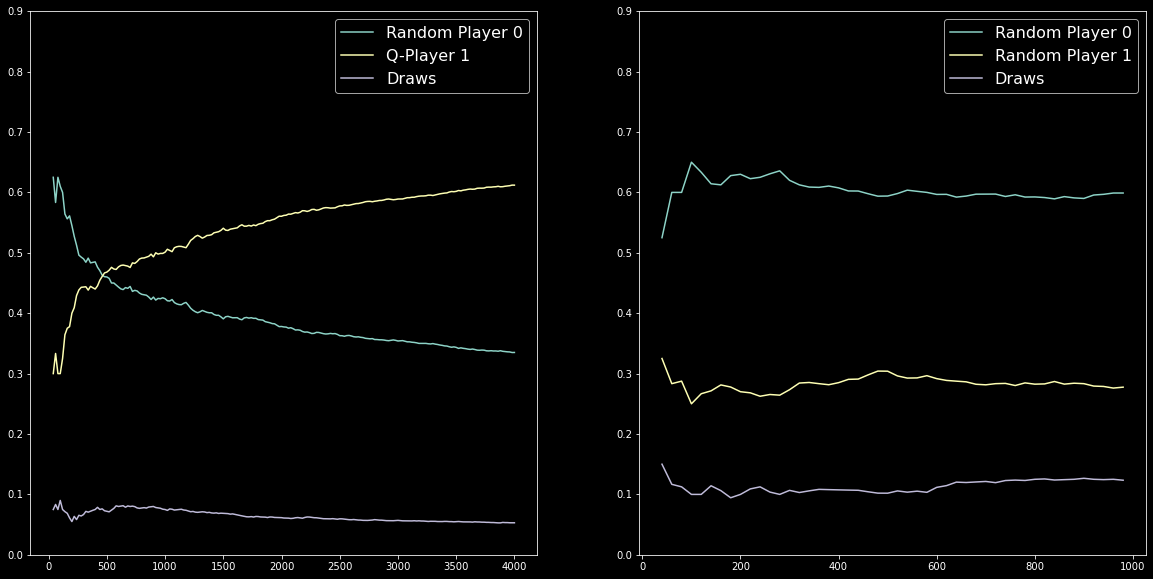

In [17]:
def plot_2_game(qstats, stats, labelA, labelB):
    qgames = range(40, len(qstats), 20)
    qwon0 = [ Counter(qstats[:x])['WIN 0']/x for x in qgames]
    qwon1 = [ Counter(qstats[:x])['WIN 1']/x for x in qgames]
    qdraw = [ Counter(qstats[:x])['DRAW']/x for x in qgames]
    games = range(40, len(stats), 20)
    won0 = [ Counter(stats[:x])['WIN 0']/x for x in games]
    won1 = [ Counter(stats[:x])['WIN 1']/x for x in games]
    draw = [ Counter(stats[:x])['DRAW']/x for x in games]


    plt.rcParams['figure.figsize'] = [20,10]
 
    fig = plt.figure();
 
    l = fig.add_subplot(121)   
    plt.ylim([0.0, 0.9])
    player0, = l.plot(qgames, qwon0, label="Random Player 0");
    player1, = l.plot(qgames, qwon1, label=labelA);
    draws, = l.plot(qgames, qdraw, label="Draws");
    l.legend(handles=[player0, player1,  draws], frameon=True, loc="best", fontsize=16);

    r = fig.add_subplot(122)  
    plt.ylim([0.0, 0.9])
    player0, = r.plot(games, won0, label="Random Player 0");
    player1, = r.plot(games, won1, label=labelB);
    draws, = r.plot(games, draw, label="Draws");
    r.legend(handles=[player0, player1,  draws], frameon=True, loc="best", fontsize=16);
    plt.show();

plot_2_game(qstats, stats, "Q-Player 1", "Random Player 1")

Counter({'WIN 1': 669, 'WIN 0': 278, 'DRAW': 53})


<Figure size 1440x720 with 0 Axes>

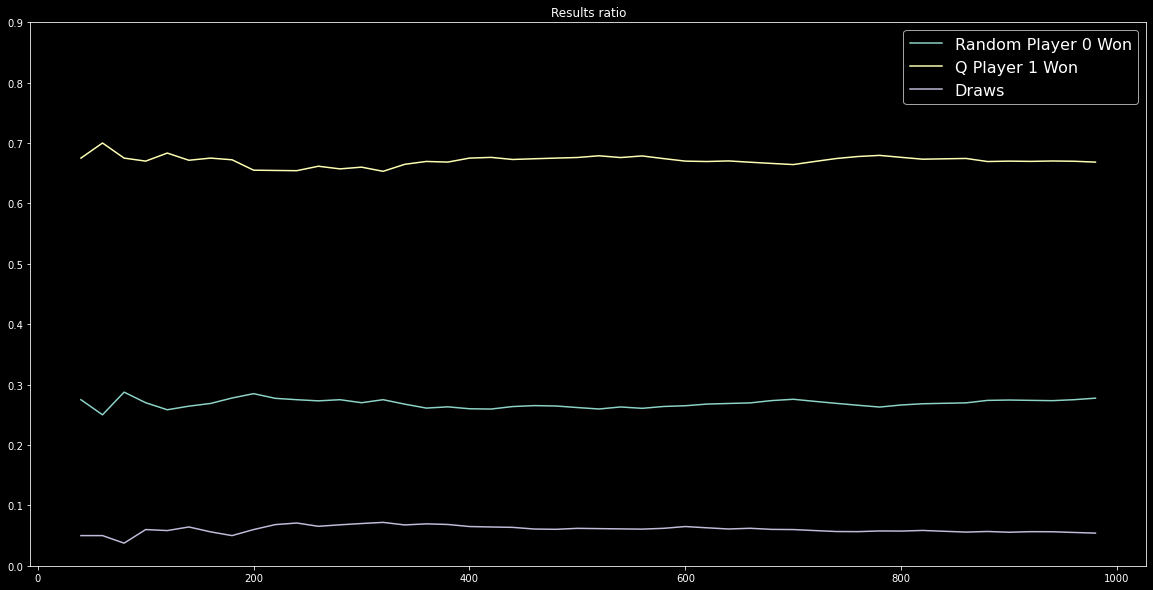

In [18]:
qstats2 = []
for i in range(1_000):
    do_game(RandomPlayer('x'), qplayer,  qstats2, False)
    
print(Counter(qstats2))
plot_games(qstats2, "Random Player 0 Won", "Q Player 1 Won")

---
## Q-Player z __*Wyżarzaniem*__

Zmniejszamy `α` przez mnożenie przez `γ` co krok - przez co spada zmienność układu

In [19]:
α = 0.99  # Tempo uczenia się - "temperatura"
β = 0.80  # Wartość początkowa `Q` - 'agresja'
γ = 0.975 # Degradacja wagi z odległością od bodźca oraz tempo spadku "temperatury"

class AnnealingQPlayer(QPlayer):
    def __init__(self, character):
        super().__init__(character)
        
    def learn(self, learned_weight):
        global α
        
        ################
        ## Wyżarzanie ##
        ################
        α *= γ
        
        super().learn(learned_weight)


In [20]:
annealing_qplayer = AnnealingQPlayer('o')

Counter({'WIN 1': 1597, 'WIN 0': 668, 'DRAW': 235})


<Figure size 1440x720 with 0 Axes>

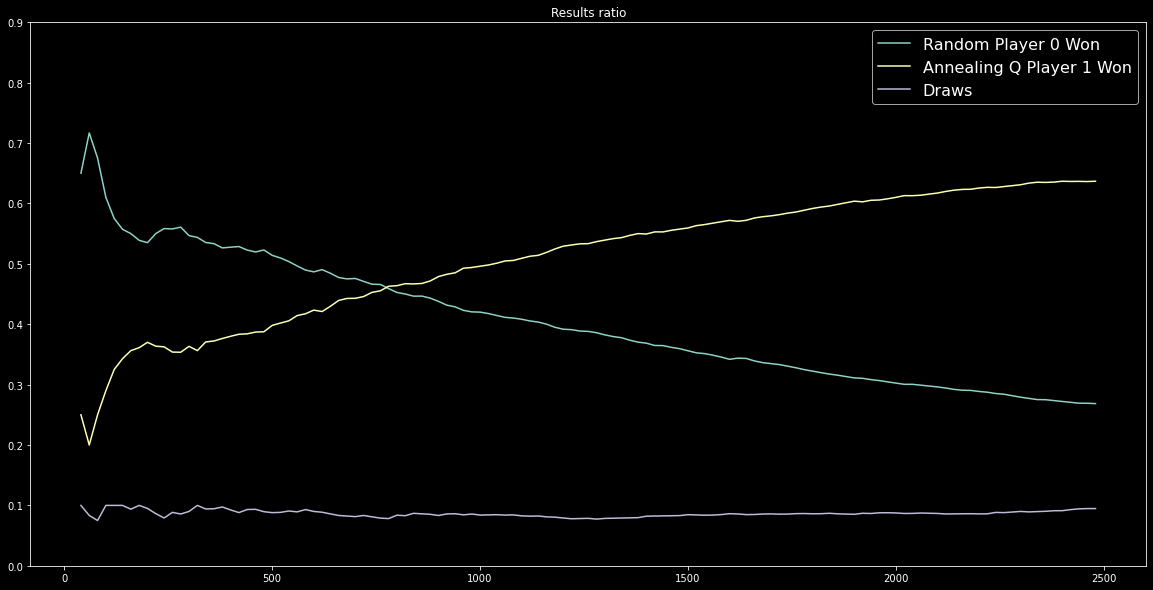

In [21]:
aqstats = []
for i in range(2_500):
    do_game(RandomPlayer('x'), annealing_qplayer,  aqstats, False)
    
print(Counter(aqstats))
plot_games(aqstats, "Random Player 0 Won", "Annealing Q Player 1 Won")

Counter({'WIN 1': 3568, 'WIN 0': 923, 'DRAW': 509})


<Figure size 1440x720 with 0 Axes>

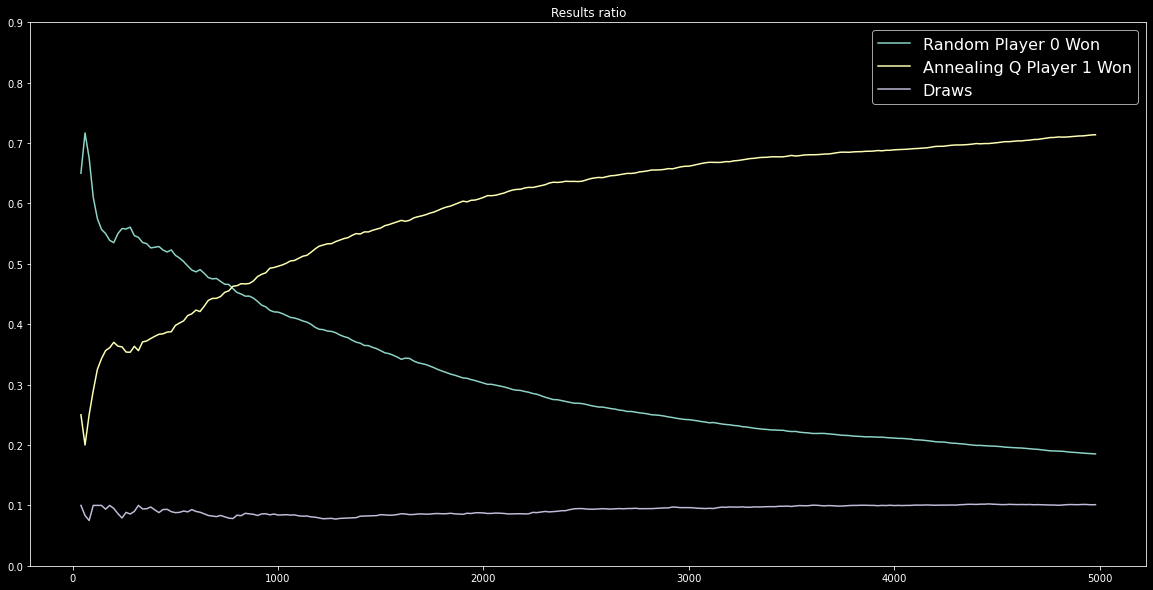

In [22]:
for i in range(2_500):
    do_game(RandomPlayer('x'), annealing_qplayer,  aqstats, False)
    
print(Counter(aqstats))
plot_games(aqstats, "Random Player 0 Won", "Annealing Q Player 1 Won")

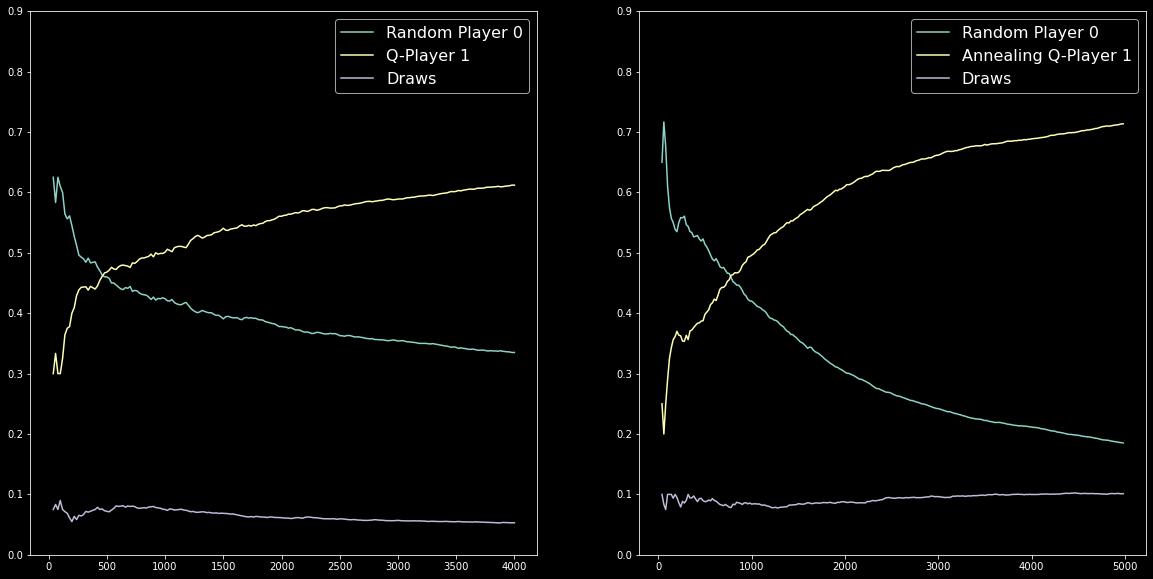

In [23]:
plot_2_game(qstats, aqstats, "Q-Player 1", "Annealing Q-Player 1")

Counter({'WIN 1': 795, 'DRAW': 137, 'WIN 0': 68})


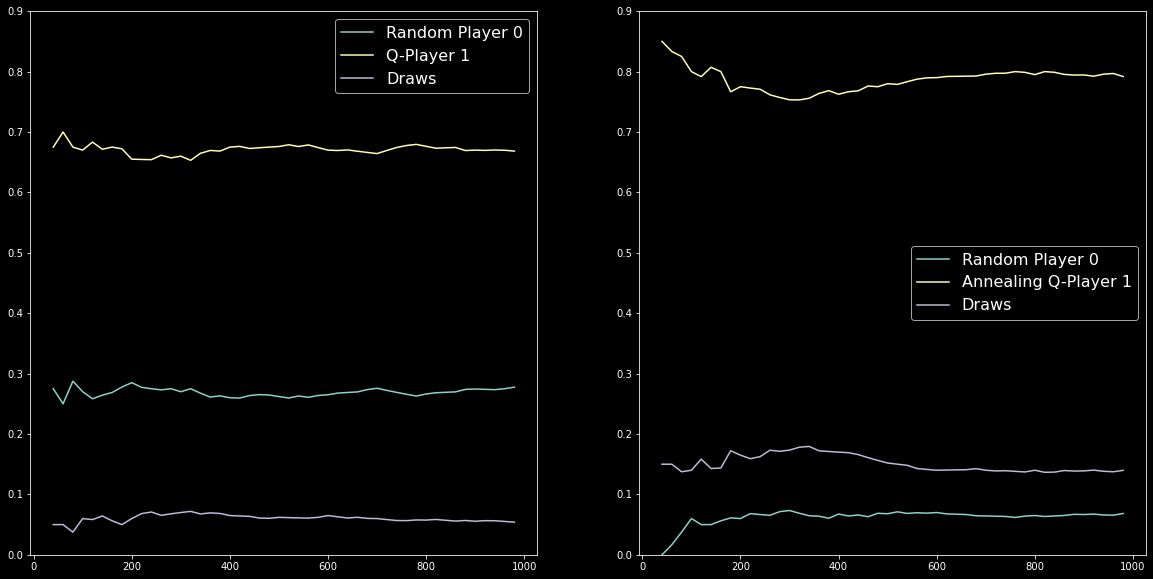

In [24]:
aqstats2 = []
for i in range(1000):
    do_game(RandomPlayer('x'), annealing_qplayer,  aqstats2, False)
    
print(Counter(aqstats2))


plot_2_game(qstats2, aqstats2, "Q-Player 1", "Annealing Q-Player 1")

---

## Za optimizely:

### __*A/B testing*__ (also known as split testing or bucket testing) is a method of __*comparing two versions*__ of a webpage or app against each other to determine which one performs __*better*__.

---
## A/B Testing ma zazwyczaj dwie fazy
- ### __*Eksploracji*__ - sprawdzamy która lepsza jest lepsza
- ### __*Eksploatacji*__ - "lepsza" wersja działa jako jedyna

## Wady typowego podejścia
- ### Nie ma płynnego przejścia z dwóch wersji na jedną
- ### W czasie eksploracji sprawdzamy wiele dużo wersji gorszych od wersji kontrolnej
- ### __*Eksploracja w praktyce nigdy się nie kończy*__

---
# Problem Wielorękiego Bandyty

![](img\Las_Vegas_slot_machines.jpg)

https://en.wikipedia.org/wiki/Multi-armed_bandit

Mamy budżet aby jak najwięcej "ugrać". Poszczególni jednoręcy bandyci różnią się między sobą szansą na wygraną. 

Ile spędzić budzetu na eksplorację najlepszej maszyny, a ile na osiągnięcie wygranej ?

Istnieje olbrzymi katalog algorytmów (ang. __bandit algorithms__) które na to odpowiadają.
- ε-greedy
- soft-max
- soft-max z wyżarzaniem
- etc. etc.

![](img\banditalgos.jpg)

---
## Algorytm ε-zachłanny - ε-greedy

- #### Z prawdopodobieństwem `1-ε`  wybieramy strategię kontrolną `A` do eksploatacji. 

- #### Z prawdopodobieństwem `ε` (np. 20%) wybieramy strategię `B`  do eksploracji. 



![](img\epsilongreedy.png)

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import random
from collections import deque
from collections import Counter


plt.style.use("dark_background")

class Experiment:
    def __init__(self, algorithm, rates):
        self.trials = deque()
        self.convertions = [0,0]
        self.algorithm = algorithm
        self.rates = rates
        self.payoff = 0
        self.arms = deque()
        
    def run(self, N):
        for i in range(N):
            arm = self.algorithm.choose_arm()
            self.arms.append(arm)
            result = (random.random() <= self.rates[arm])
            self.trials.append((arm, result))
            if result:
                self.payoff += 1
                self.convertions[arm] += 1
            self.algorithm.update(arm, result)
            

class Algorithm:
    def update(self, arm, result):
        pass
    def choose_arm(self):
        pass
    
    
class EpsilonGreedy(Algorithm):
    def __init__(self, ε):
        self.ε = ε
        
    def choose_arm(self):
        return 1 if (random.random() <= self.ε) else 0
    
    
experiment_1 =  Experiment(EpsilonGreedy(0.2), [0.020, 0.025])   

experiment_1.run(100_000)
print(experiment_1.payoff)

2077


In [26]:
def prepare_data(experiment, step):
    list_trials= list(experiment.trials)
    trials = range(0, len(experiment.trials), step)
    results = [ Counter(list_trials[x-step:x]) for x in trials]
    arm0_results = [0]+[ c[(0,True)] for c in results]
    arm0 = [ 0 ]
    for x in range(len(arm0_results)-2):
        arm0.append(arm0_results[x+1]+arm0[x])
    arm1_results = [0]+[ c[(1,True)] for c in results]
    arm1 = [ 0 ]
    for x in range(len(arm1_results)-2):
        arm1.append(arm1_results[x+1]+arm1[x])
    payoff_results = [0]+[ c[(0,True)]+c[(1,True)] for c in results]
    payoff = [ 0 ]
    for x in range(len(payoff_results)-2):
        payoff.append(payoff_results[x+1]+payoff[x])
    
    arms = list(experiment.arms)
    arm_ratios =  [ Counter(arms[x-step:x])[0]/step for x in trials]
    arm_ratios[0] = arm_ratios[1] 
    return trials, arm0, arm1, payoff, arm_ratios

def plot_experiment(experiment, step=500):
    trials, arm0, arm1, payoff, arm_ratios = prepare_data(experiment, step)
    
    plt.rcParams['figure.figsize'] = [20,10]
 
    fig, ax = plt.subplots()
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    l = fig.add_subplot(111)   
    arm0, = l.plot(trials, arm0, label="Arm 0 - 'A'");
    arm1, = l.plot(trials, arm1, label="Arm 1 - 'B'");
    payoff_handle, = l.plot(trials, payoff, label="Payoff");
    ax.ticklabel_format(useOffset=True, style='plain')
    ax2=ax.twinx()
    ax2.set_ylim([0.0, 1.0])
    ratio, = ax2.plot(trials, arm_ratios,  "b-", label="% Arm 0")
    l.legend(handles=[arm0, arm1, payoff_handle, ratio], frameon=True, loc="upper center", fontsize=16);

    plt.show();

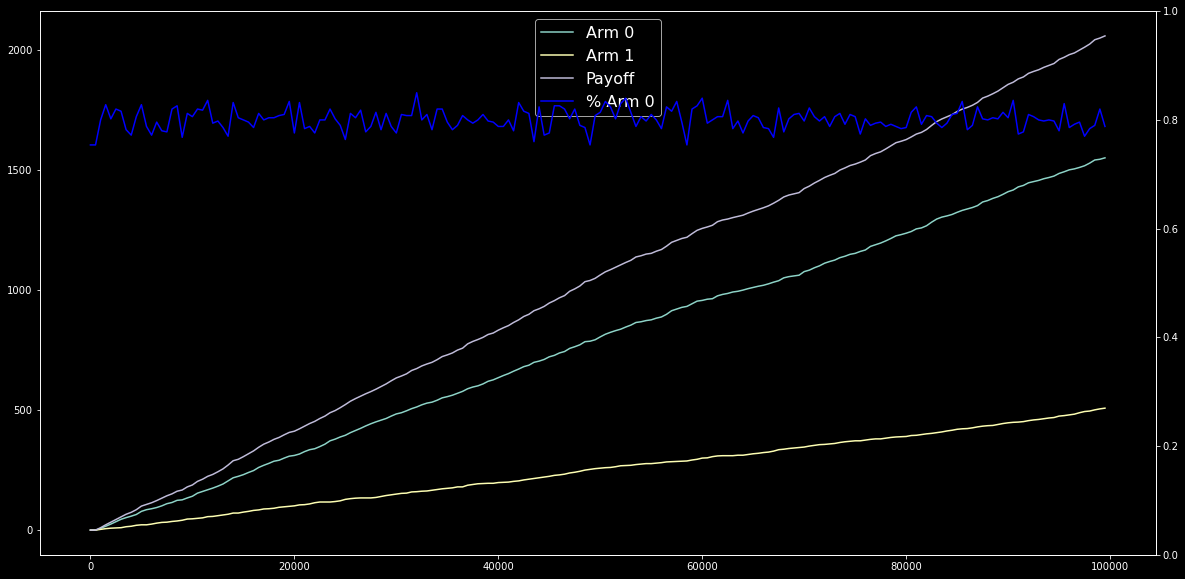

In [27]:
plot_experiment(experiment_1)

In [28]:
class EpsilonFirst(Algorithm):
    def __init__(self, ε, N):
        self.ε = ε
        self.N = N
        self.counter = 0
        self.arm_results = [0, 0]

    def update(self, arm, result):   
        self.counter += 1
        if result:
            self.arm_results[arm] += 1
            
        
    def choose_arm(self):
        N = self.N
        ε = self.ε
        if self.counter < N*ε:
            self.choice = 0 if self.arm_results[0] > self.arm_results[1] else 1
            
            return 1 if (random.random() <= 0.5) else 0
        
        return self.choice

In [29]:
N = 100_000
experiment_2 =  Experiment(EpsilonFirst(0.3, N), [0.020, 0.025])   

experiment_2.run(N)

print(experiment_2.payoff)

2410


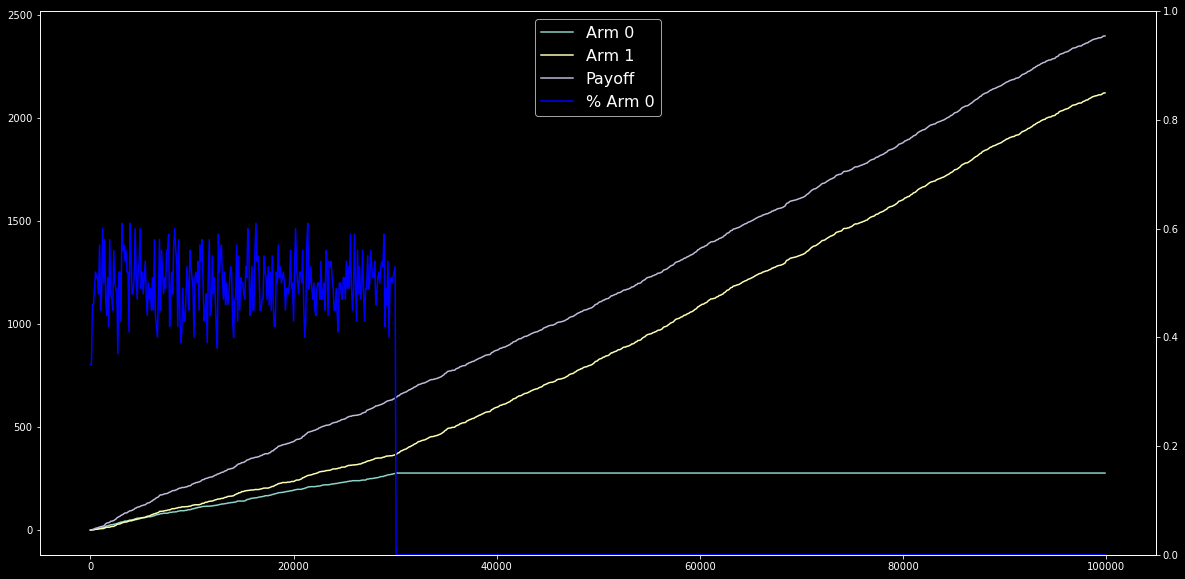

In [30]:
plot_experiment(experiment_2, step=100)

In [31]:
N = 100_000
random.seed(1)
experiment_3 =  Experiment(EpsilonFirst(0.1, N), [0.020, 0.021])   

experiment_3.run(N)

print(experiment_3.payoff)

2008


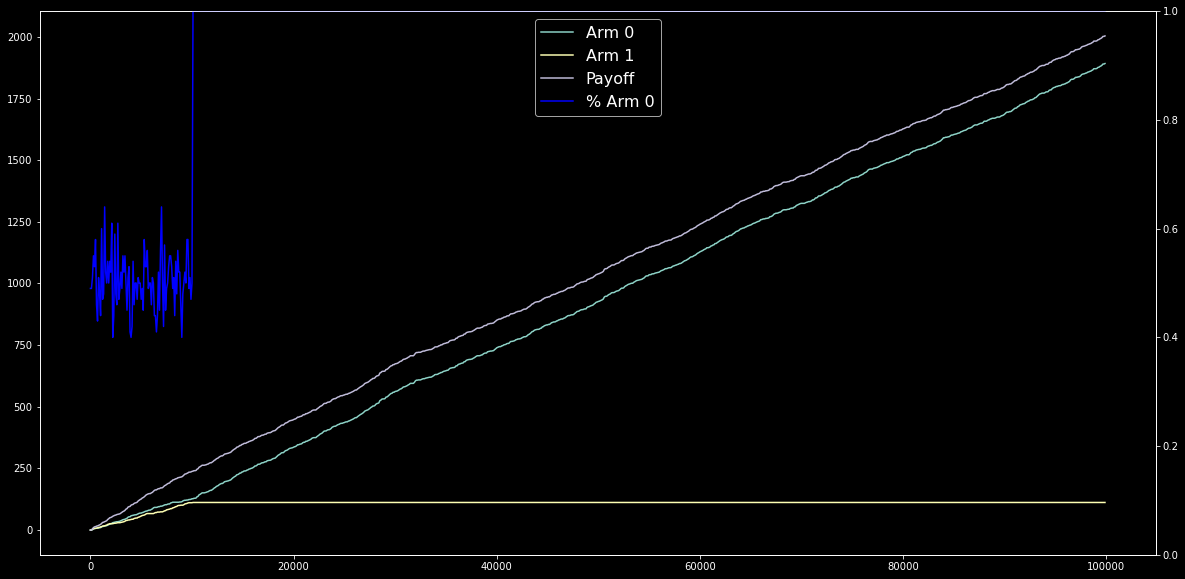

In [32]:
plot_experiment(experiment_3, step=100)

---
## Algorytm Soft-max

#### $r_A$ - proporcja sukcesów w gałęzi `A`

#### $r_B$ - proporcja sukcesów w gałęzi `B`

<br>

- #### Wybieramy strategię kontrolną `A` z prawdopodobieństwem 

### $$P(A) = \frac{r_A}{r_A+r_B}$$ 

- #### Wybieramy strategię `B` z prawdopodobieństwem 

### $$P(B) = \frac{r_B}{r_A+r_B}$$ 

In [33]:
class SoftMax(Algorithm):
    def __init__(self, initial_value=5):
        self.arm_results = [initial_value, initial_value]

    def update(self, arm, result):   
        if result:
            self.arm_results[arm] += 1
            
    def choose_arm(self):
        a = self.arm_results[0]
        b = self.arm_results[1]
        r_a = (a / (a+b)) 
        return 0 if random.random() < r_a else 1

In [34]:
N = 100_000
experiment_4 =  Experiment(SoftMax(), [0.020, 0.025])   

experiment_4.run(N)
print(experiment_4.payoff)

2407


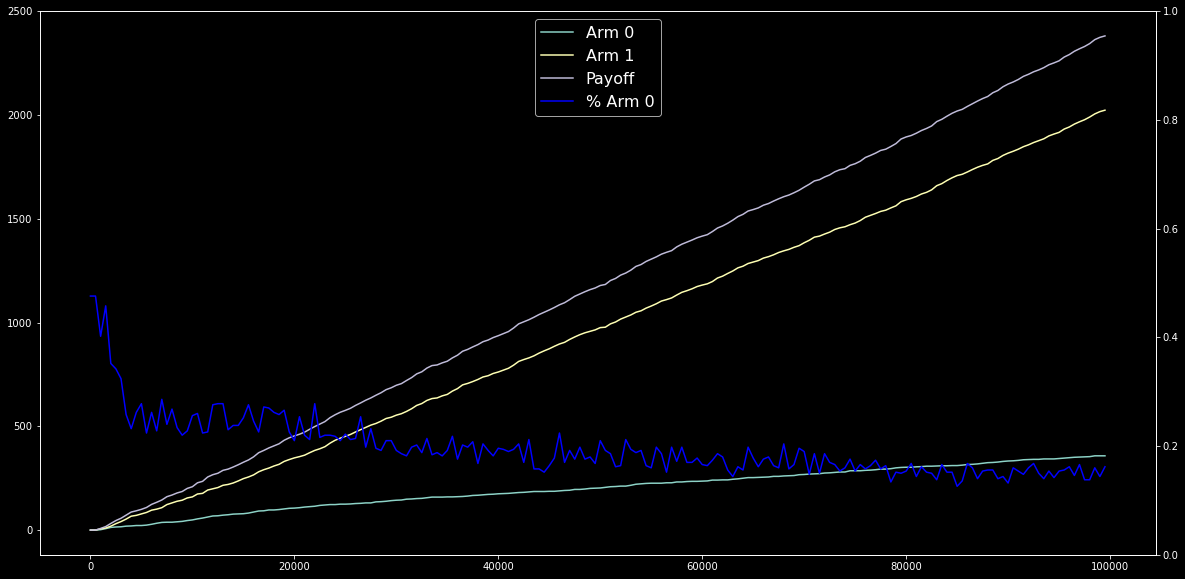

In [35]:
plot_experiment(experiment_4)


---
## __*Wyżarzanie*__ (ang. simulated annealing)

### __*Wyżarzanie*__ - to obniżanie "temperatury" czyli zmienności układu z czasem

### Dzięki __*wyżarzaniu*__ - system z czasem coraz rzadziej eksploruje.

#### __*Hartowanie*__ to zwiększanie temperatury raz na jakiś czas aby "wybić" system z minimów lokalnych 

---
## Algorytm Soft-max z wyżarzaniem

- #### $r_A$ - proporcja sukcesów w gałęzi `A`

- #### $r_B$ - proporcja sukcesów w gałęzi `B`

- #### $\tau$ - "temperatura"


### Gdzie:

`t = sum(self.counts) + 1` - licznik __czasu__

`τ = 1 / math.log(t + 0.0000001)` - dla kroku `1` - bardzo duża, później maleje


<br>

- #### wybieramy strategię kontrolną `A` z prawdopodobieństwem

### $$p(A) = \frac{exp(r_A/\tau)}{exp(r_A/\tau)+exp(r_B/\tau)}$$ 


- #### wybieramy strategię `B`  z prawdopodobieństwem 

### $$p(B) = \frac{exp(r_B/\tau)}{exp(r_A/\tau)+exp(r_B/\tau)}$$ 

---


In [ ]:
from numpy import exp, log

class AnnealingSoftMax(Algorithm):

    def __init__(self, initial_value = 200):
        self.arm_results = [initial_value, initial_value]
        self.count=0

    def update(self, arm, result):   
        if result:
            self.arm_results[arm] += 1
            
    def choose_arm(self):        
        self.count += 1
        a = self.arm_results[0]
        b = self.arm_results[1]
        r_a = (a / (a+b)) 
        r_b = (b / (a+b)) 
        t = self.count
        τ = 1 / log(t + 0.0000001) # w pierwszym kroku - 1 / math.log(1.0000001)

        a_0 = exp(r_a/τ)
        b_0 = exp(r_b/τ)
        
        return 0 if random.random() < (a_0 / (a_0+b_0)) else 1

In [ ]:
N = 100_000
experiment_5 =  Experiment(AnnealingSoftMax(), [0.020, 0.025])   

experiment_5.run(N)
print(experiment_5.payoff)

In [ ]:
plot_experiment(experiment_5)

In [ ]:
N = 100_000
experiment_6 =  Experiment(AnnealingSoftMax(1000), [0.020, 0.025])   

experiment_6.run(N)
print(experiment_6.payoff)
plot_experiment(experiment_6)

---
# Materiały

- https://en.wikipedia.org/wiki/Q-learning

- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html

- https://tor-lattimore.com/downloads/book/book.pdf - Bandit Algorithms, Tor Lattimore and Csaba Szepesv´ari
---

In [ ]:
do_game(HumanPlayer('x'), annealing_qplayer, [], True)